# Zero-Shot Learning

## 1) Generic Zero-Shot Learning

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Using a lightweight, fast model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

In [59]:
# Input text we want to classify
text = "Opposition party gains ground ahead of national election."

# Candidate labels representing potential categories
labels = ["economics", "sports", "politics"]

# --- Generating Embeddings ---
# Encode the input text and labels to obtain dense vector representations
embed_text = model.encode([text])  # Shape: (1, 384)
embed_labels = model.encode(labels)  # Shape: (3, 384)

Similarity Scores: [0.5695807 0.5388421 0.660658 ]


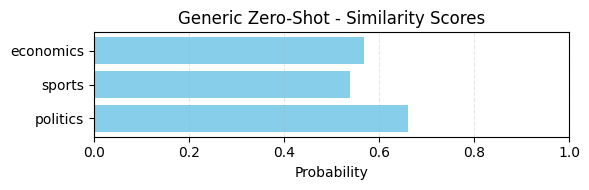

In [60]:
# Compute cosine similarity between the text and each label
# Cosine similarity ranges from -1 to 1, so we rescale it to [0, 1] for interpretability
sim_matrix = cosine_similarity(embed_text, embed_labels)
sim_matrix = (sim_matrix + 1) / 2 
print("Similarity Scores:", sim_matrix[0])

plt.figure(figsize=(6, 2))
plt.barh(labels, sim_matrix.flatten(), color='skyblue')
plt.xlabel("Probability")
plt.title("Generic Zero-Shot - Similarity Scores")
plt.xlim(0, 1)  # Ensure the x-axis is within [0, 1] for clarity
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, linestyle='--', axis='x')
plt.tight_layout()
plt.show()

## 2) Zero-Shot classifier using NLI

+ It uses a model like BART or RoBERTa trained on MNLI to determine how likely a piece of text (premise) entails a hypothesis (constructed from each label).

In [37]:
import torch
import matplotlib.pyplot as plt

def ZeroShotNLI(tokenizer, model, text, candidate_labels, multi_label=False, plot=False):
    """
    Perform zero-shot classification using a Natural Language Inference (NLI) model.

    This function reformulates each candidate label as a hypothesis and computes the likelihood 
    that the input text (premise) entails each hypothesis. It supports both single-label 
    (multi-class) and multi-label classification modes.

    Parameters
    ----------
    tokenizer : transformers.PreTrainedTokenizer
        The tokenizer associated with the pre-trained NLI model.
    model : transformers.PreTrainedModel
        The NLI model used to predict entailment probabilities.
    text : str
        The input text to classify (used as the premise in the NLI formulation).
    candidate_labels : List[str]
        A list of labels, each of which will be turned into a natural language hypothesis.
    multi_label : bool, optional (default=False)
        - If False, assumes only one label is true (mutually exclusive labels).
        - If True, multiple labels can be simultaneously "true".

    Returns
    -------
    dict
        A dictionary with:
            - "sequence": The input text.
            - "labels": The original list of candidate labels.
            - "scores": Probabilities corresponding to each label.
    """
    # Template to transform each label into a natural language hypothesis
    hypothesis_template = "This text is about {}."
    hypotheses = [hypothesis_template.format(label) for label in candidate_labels]

    # Identify the position of "entailment" in the model's output logits
    entailment_id = model.config.label2id.get("entailment", 2)

    # Tokenize the (premise, hypothesis) pairs
    inputs = tokenizer(
        [text] * len(hypotheses), 
        hypotheses, 
        return_tensors='pt', 
        padding=True,
        truncation=True
    )

    # Run the model
    with torch.no_grad():
        logits = model(**inputs).logits

    # Multi-label or single-label logic
    if multi_label or len(candidate_labels) == 1:
        # Apply softmax over [contradiction, entailment] for each label independently
        entail_contr_logits = logits[:, [0, entailment_id]]
        probs = torch.softmax(entail_contr_logits, dim=1)
        entail_probs = probs[:, 1]
    else:
        # Apply softmax over all labels (single-label setting)
        entail_logits = logits[:, entailment_id]
        entail_probs = torch.softmax(entail_logits, dim=0)

    # Convert to Python list for easy interpretation
    entail_probs = entail_probs.tolist()

    # Plot the probabilities
    if plot:
        plt.figure(figsize=(6, 2))
        plt.barh(candidate_labels, entail_probs, color='skyblue')
        plt.xlabel("Probability")
        plt.title(f"Zero-Shot NLI Classification")
        plt.gca().invert_yaxis()
        plt.grid(alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()

    return {
        "sequence": text,
        "labels": candidate_labels,
        "scores": entail_probs
    }

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name='facebook/bart-large-mnli' # 'roberta-large-mnli'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

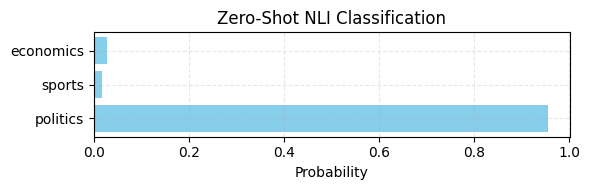

{'sequence': 'Opposition party gains ground ahead of national election.',
 'labels': ['economics', 'sports', 'politics'],
 'scores': [0.027808941900730133, 0.01725943200290203, 0.9549316167831421]}

In [39]:
text = "Opposition party gains ground ahead of national election."
labels = ["economics", "sports", "politics"]

ZeroShotNLI(tokenizer, model, text, labels, plot=True)

### Multi_label
- If `multi_label=False`, assumes only one label is true (mutually exclusive labels).
- If `multi_label=True`, multiple labels can be simultaneously "true".

In [40]:
ZeroShotNLI(tokenizer, model, text, labels, multi_label=True)

{'sequence': 'Opposition party gains ground ahead of national election.',
 'labels': ['economics', 'sports', 'politics'],
 'scores': [0.018083617091178894, 0.0009368736646138132, 0.9750287532806396]}